In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt

from helper import construct_dataset_for_ml

In [14]:
df = construct_dataset_for_ml()

Processing asset 1 of 97 (BNB/USDT on BINANCE)...
Processing asset 2 of 97 (ADA/USDC on KUCOIN)...
Processing asset 3 of 97 (DYDX/USDT on OKEX)...
Processing asset 4 of 97 (ANKR/USDT on KUCOIN)...
Processing asset 5 of 97 (ZIL/USDT on OKEX)...
Processing asset 6 of 97 (HBAR/USDC on OKEX)...
Skipping asset due to 28.70% missing price_close data
Processing asset 7 of 97 (STX/USDT on OKEX)...
Processing asset 8 of 97 (FTM/USDC on KUCOIN)...
Processing asset 9 of 97 (DOGE/USDT on BITFINEX)...
Processing asset 10 of 97 (OCEAN/USDT on POLONIEX)...
Skipping asset due to 39.76% missing price_close data
Processing asset 11 of 97 (ETC/USDC on POLONIEX)...
Skipping asset due to 67.44% missing price_close data
Processing asset 12 of 97 (FIL/USDT on BINANCE)...
Processing asset 13 of 97 (CRO/USDC on OKEX)...
Processing asset 14 of 97 (ICP/USDT on KUCOIN)...
Processing asset 15 of 97 (BNB/USDT on KUCOIN)...
Processing asset 16 of 97 (EOS/USDT on BINANCE)...
Processing asset 17 of 97 (CRV/USDT on KUC

<Axes: xlabel='time_period_end'>

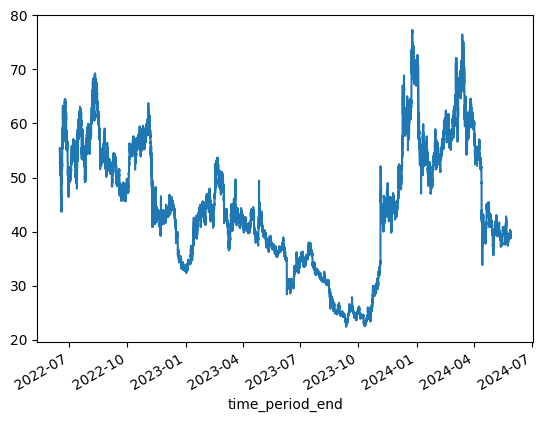

In [38]:
nxra = df[(df['asset_id_base'] == 'EGLD') & (df['asset_id_quote'] == 'USD') & (df['exchange_id'] == 'KRAKEN')]
nxra.price_close.plot()

In [30]:
# Downcast to save memory
df['asset_id_base'] = df['asset_id_base'].astype('category')
df['asset_id_quote'] = df['asset_id_quote'].astype('category')
df['exchange_id'] = df['exchange_id'].astype('category')

numeric_cols = [col for col in df.columns if col not in ('asset_id_base', 'asset_id_quote', 'exchange_id')]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, downcast='float')

In [31]:
# Memory usage in GB
print(df.memory_usage(deep=True).sum() / 1e9, 'GB')

0.247179749 GB


In [32]:
df.shape

(4494087, 10)

<Axes: >

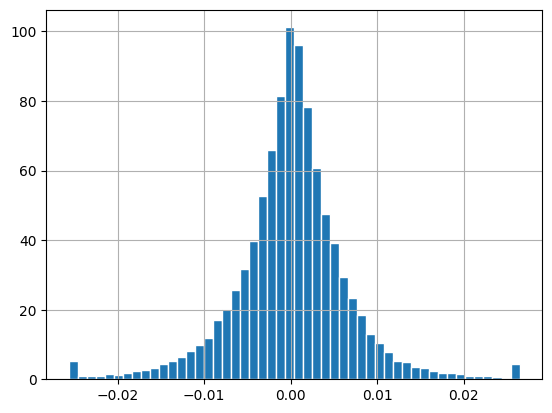

In [41]:
nxra.returns.hist(ec = 'w', bins = 50, density = True)